In [15]:
import os
import numpy as np
import torch
from model import AttentionModel
from environment import CPDPTW, CPDPTWDataset
from train import train_epoch, validate
from baseline import RolloutBaseline
from tensorboard_logger import Logger as TbLogger

In [2]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--problem', default='cvrp', help="The problem to solve, default 'cvrp'")
parser.add_argument('--graph_size', type=int, default=100, help="The size of the problem graph")
parser.add_argument('--batch_size', type=int, default=512, help='Number of instances per batch during training')
parser.add_argument('--epoch_size', type=int, default=1280000, help='Number of instances per epoch during training')
parser.add_argument('--val_size', type=int, default=10000,
                    help='Number of instances used for reporting validation performance')
parser.add_argument('--val_dataset', type=str, default=None, help='Dataset file to use for validation')
parser.add_argument('--data_path', type=str, default=None, help='Path to data file to use for training')
# Model
parser.add_argument('--model', default='attention', help="Model, 'attention' (default) or 'pointer'")
parser.add_argument('--embedding_dim', type=int, default=128, help='Dimension of input embedding')
parser.add_argument('--hidden_dim', type=int, default=128, help='Dimension of hidden layers in Enc/Dec')
parser.add_argument('--n_encode_layers', type=int, default=3,
                    help='Number of layers in the encoder/critic network')
parser.add_argument('--tanh_clipping', type=float, default=10.,
                    help='Clip the parameters to within +- this value using tanh. '
                            'Set to 0 to not perform any clipping.')
parser.add_argument('--normalization', default='batch', help="Normalization type, 'batch' (default) or 'instance'")
parser.add_argument('--num_workers', type=int, default=0, help='Number of data loading workers')
# Training
parser.add_argument('--lr_model', type=float, default=1e-4, help="Set the learning rate for the actor network")
parser.add_argument('--lr_critic', type=float, default=1e-4, help="Set the learning rate for the critic network")
parser.add_argument('--lr_decay', type=float, default=1.0, help='Learning rate decay per epoch')
parser.add_argument('--eval_only', action='store_true', help='Set this value to only evaluate model')
parser.add_argument('--n_epochs', type=int, default=10, help='The number of epochs to train')
parser.add_argument('--seed', type=int, default=1234, help='Random seed to use')
parser.add_argument('--max_grad_norm', type=float, default=1.0,
                    help='Maximum L2 norm for gradient clipping, default 1.0 (0 to disable clipping)')
parser.add_argument('--no_cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--exp_beta', type=float, default=0.8,
                    help='Exponential moving average baseline decay (default 0.8)')
parser.add_argument('--baseline', default=None,
                    help="Baseline to use: 'rollout', 'critic' or 'exponential'. Defaults to no baseline.")
parser.add_argument('--bl_alpha', type=float, default=0.05,
                    help='Significance in the t-test for updating rollout baseline')
parser.add_argument('--bl_warmup_epochs', type=int, default=None,
                    help='Number of epochs to warmup the baseline, default None means 1 for rollout (exponential '
                            'used for warmup phase), 0 otherwise. Can only be used with rollout baseline.')
parser.add_argument('--eval_batch_size', type=int, default=1024,
                    help="Batch size to use during (baseline) evaluation")
parser.add_argument('--checkpoint_encoder', action='store_true',
                    help='Set to decrease memory usage by checkpointing encoder')
parser.add_argument('--shrink_size', type=int, default=None,
                    help='Shrink the batch size if at least this many instances in the batch are finished'
                            ' to save memory (default None means no shrinking)')
parser.add_argument('--data_distribution', type=str, default=None,
                    help='Data distribution to use during training, defaults and options depend on problem.')

# Misc
parser.add_argument('--log_step', type=int, default=50, help='Log info every log_step steps')
parser.add_argument('--log_dir', default='logs', help='Directory to write TensorBoard information to')
parser.add_argument('--run_name', default='run', help='Name to identify the run')
parser.add_argument('--output_dir', default='outputs', help='Directory to write output models to')
parser.add_argument('--epoch_start', type=int, default=0,
                    help='Start at epoch # (relevant for learning rate decay)')
parser.add_argument('--checkpoint_epochs', type=int, default=1,
                    help='Save checkpoint every n epochs (default 1), 0 to save no checkpoints')
parser.add_argument('--load_path', help='Path to load model parameters and optimizer state from')
parser.add_argument('--resume', help='Resume from previous checkpoint file')
parser.add_argument('--no_tensorboard', action='store_true', help='Disable logging TensorBoard files')
parser.add_argument('--no_progress_bar', action='store_true', help='Disable progress bar')

opts, unknown = parser.parse_known_args()

In [3]:
opts.save_dir = os.path.join(
        opts.output_dir,
        "{}_{}".format(opts.problem, opts.graph_size),
        opts.run_name
    )

if not os.path.exists(opts.save_dir):
    os.makedirs(opts.save_dir)

In [4]:
tb_logger = None
if not opts.no_tensorboard:
    tb_logger = TbLogger(os.path.join(opts.log_dir, "{}_{}".format(opts.problem, opts.graph_size), opts.run_name))

In [5]:
opts.data_path = 'D:/OneDrive - Hanoi University of Science and Technology/Projects/Project 1/Data/Sartori&Buriol/Instances/n100'
opts.device = torch.device("cuda" if not opts.no_cuda and torch.cuda.is_available() else "cpu")

In [6]:
problem = CPDPTW()

In [7]:
model = AttentionModel(
    embed_dim=128,
    hidden_dim=128,
    problem=problem,
    n_encode_layers=3,
    tanh_clipping=10.,
    mask_inner=True,
    mask_logits=True,
    normalization='batch',
    n_heads=8,
    checkpoint_encoder=False,
    shrink_size=None
)

In [8]:
baseline = RolloutBaseline(model, problem, opts)

Evaluating baseline model on evaluation dataset


100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


In [9]:
import torch.optim as optim

optimizer = optim.Adam(
        [{'params': model.parameters(), 'lr': opts.lr_model}]
        + (
            [{'params': baseline.get_learnable_parameters(), 'lr': opts.lr_critic}]
            if len(baseline.get_learnable_parameters()) > 0
            else []
        )
    )

In [10]:
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: opts.lr_decay ** epoch)

In [11]:
val_dataset = problem.make_dataset(opts.data_path)

In [25]:
if opts.eval_only:
    validate(model, val_dataset, opts)
else:
    for epoch in range(opts.epoch_start, opts.epoch_start + opts.n_epochs):
        train_epoch(
            model,
            optimizer,
            baseline,
            lr_scheduler,
            epoch,
            val_dataset,
            problem,
            tb_logger,
            opts
        )

Start train epoch 0, lr=0.0001 for run run
Evaluating baseline on dataset...


100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


epoch: 0, train_batch_id: 0, avg_cost: 8.773138999938965
grad_norm: 54.10213851928711, clipped: 1.0
Finished epoch 0, took 00:00:05 s
Saving model and state...
Validating...


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Validation overall avg_cost: 8.548629760742188 +- 0.9072553515434265
Evaluating candidate model on evaluation dataset


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Epoch 0 candidate mean 8.548630714416504, baseline epoch 0 mean 8.838610649108887, difference -0.2899799346923828
p-value: 0.06618560615838666
Start train epoch 1, lr=0.0001 for run run
Evaluating baseline on dataset...


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


epoch: 1, train_batch_id: 0, avg_cost: 8.93103313446045
grad_norm: 40.60211944580078, clipped: 1.0
Finished epoch 1, took 00:00:05 s
Saving model and state...
Validating...


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Validation overall avg_cost: 8.626686096191406 +- 0.9134922027587891
Evaluating candidate model on evaluation dataset


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Epoch 1 candidate mean 8.626687049865723, baseline epoch 0 mean 8.838610649108887, difference -0.21192359924316406
p-value: 0.1615461122389299
Start train epoch 2, lr=0.0001 for run run
Evaluating baseline on dataset...


100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


epoch: 2, train_batch_id: 0, avg_cost: 8.750760078430176
grad_norm: 50.30488204956055, clipped: 1.0
Finished epoch 2, took 00:00:05 s
Saving model and state...
Validating...


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Validation overall avg_cost: 8.577609062194824 +- 0.865754246711731
Evaluating candidate model on evaluation dataset


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Epoch 2 candidate mean 8.577609062194824, baseline epoch 0 mean 8.838610649108887, difference -0.2610015869140625
p-value: 0.10219430082576786
Start train epoch 3, lr=0.0001 for run run
Evaluating baseline on dataset...


100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


epoch: 3, train_batch_id: 0, avg_cost: 8.763425827026367
grad_norm: 42.30970001220703, clipped: 1.0
Finished epoch 3, took 00:00:05 s
Saving model and state...
Validating...


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Validation overall avg_cost: 8.626225471496582 +- 0.8988078832626343
Evaluating candidate model on evaluation dataset


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 3 candidate mean 8.626226425170898, baseline epoch 0 mean 8.838610649108887, difference -0.21238422393798828
p-value: 0.15292845679785608
Start train epoch 4, lr=0.0001 for run run
Evaluating baseline on dataset...


100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


epoch: 4, train_batch_id: 0, avg_cost: 8.705442428588867
grad_norm: 45.720001220703125, clipped: 1.0
Finished epoch 4, took 00:00:05 s
Saving model and state...
Validating...


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Validation overall avg_cost: 8.568445205688477 +- 0.887193500995636
Evaluating candidate model on evaluation dataset


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 4 candidate mean 8.568445205688477, baseline epoch 0 mean 8.838610649108887, difference -0.27016544342041016
p-value: 0.11973376838559216
Start train epoch 5, lr=0.0001 for run run
Evaluating baseline on dataset...


100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


epoch: 5, train_batch_id: 0, avg_cost: 8.685710906982422
grad_norm: 53.008705139160156, clipped: 1.0
Finished epoch 5, took 00:00:04 s
Saving model and state...
Validating...


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Validation overall avg_cost: 8.539624214172363 +- 0.8783224821090698
Evaluating candidate model on evaluation dataset


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 5 candidate mean 8.539624214172363, baseline epoch 0 mean 8.838610649108887, difference -0.29898643493652344
p-value: 0.10492374860890538
Start train epoch 6, lr=0.0001 for run run
Evaluating baseline on dataset...


100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


epoch: 6, train_batch_id: 0, avg_cost: 8.825522422790527
grad_norm: 43.35481643676758, clipped: 1.0
Finished epoch 6, took 00:00:04 s
Saving model and state...
Validating...


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Validation overall avg_cost: 8.502803802490234 +- 0.8654193878173828
Evaluating candidate model on evaluation dataset


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 6 candidate mean 8.502803802490234, baseline epoch 0 mean 8.838610649108887, difference -0.33580684661865234
p-value: 0.07612681920025759
Start train epoch 7, lr=0.0001 for run run
Evaluating baseline on dataset...


100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


epoch: 7, train_batch_id: 0, avg_cost: 8.662323951721191
grad_norm: 40.14019775390625, clipped: 1.0
Finished epoch 7, took 00:00:05 s
Saving model and state...
Validating...


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Validation overall avg_cost: 8.646930694580078 +- 0.8909560441970825
Evaluating candidate model on evaluation dataset


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Epoch 7 candidate mean 8.646929740905762, baseline epoch 0 mean 8.838610649108887, difference -0.191680908203125
p-value: 0.2070392609148033
Start train epoch 8, lr=0.0001 for run run
Evaluating baseline on dataset...


100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


epoch: 8, train_batch_id: 0, avg_cost: 8.763991355895996
grad_norm: 32.55123519897461, clipped: 1.0
Finished epoch 8, took 00:00:05 s
Saving model and state...
Validating...


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Validation overall avg_cost: 8.611498832702637 +- 0.8746757507324219
Evaluating candidate model on evaluation dataset


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 8 candidate mean 8.611498832702637, baseline epoch 0 mean 8.838610649108887, difference -0.22711181640625
p-value: 0.13785556061195478
Start train epoch 9, lr=0.0001 for run run
Evaluating baseline on dataset...


100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


epoch: 9, train_batch_id: 0, avg_cost: 8.901230812072754
grad_norm: 32.1197624206543, clipped: 1.0
Finished epoch 9, took 00:00:05 s
Saving model and state...
Validating...


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Validation overall avg_cost: 8.521906852722168 +- 0.837713897228241
Evaluating candidate model on evaluation dataset


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Epoch 9 candidate mean 8.521905899047852, baseline epoch 0 mean 8.838610649108887, difference -0.31670475006103516
p-value: 0.07059761186753942


In [26]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def discrete_cmap(N, base_cmap=None):
  """
    Create an N-bin discrete colormap from the specified input map
    """
  # Note that if base_cmap is a string or None, you can simply do
  #    return plt.cm.get_cmap(base_cmap, N)
  # The following works for string, None, or a colormap instance:

  base = plt.cm.get_cmap(base_cmap)
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """
    
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['coords'][0, :].cpu().numpy()
    locs = data['coords'][1:, :].cpu().numpy()
    demands = data['demand'].cpu().numpy() * demand_scale
    capacity = demand_scale # Capacity is always 1
    
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    # ax1.set_xlim(0, 1)
    # ax1.set_ylim(0, 1)
    
    legend = ax1.legend(loc='upper center')
    
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            
            x_prev, y_prev = x, y
            cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, # {}, c {} / {}, d {:.2f}'.format(
                veh_number, 
                len(r), 
                int(total_route_demand) if round_demand else total_route_demand, 
                int(capacity) if round_demand else capacity,
                dist
            )
        )
        
        qvs.append(qv)
        
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs)
    
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')
    
    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)

C:\Users\DELL\AppData\Local\Temp\ipykernel_32620\2838297997.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax1.legend(loc='upper center')
C:\Users\DELL\AppData\Local\Temp\ipykernel_32620\2838297997.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap(base_cmap)


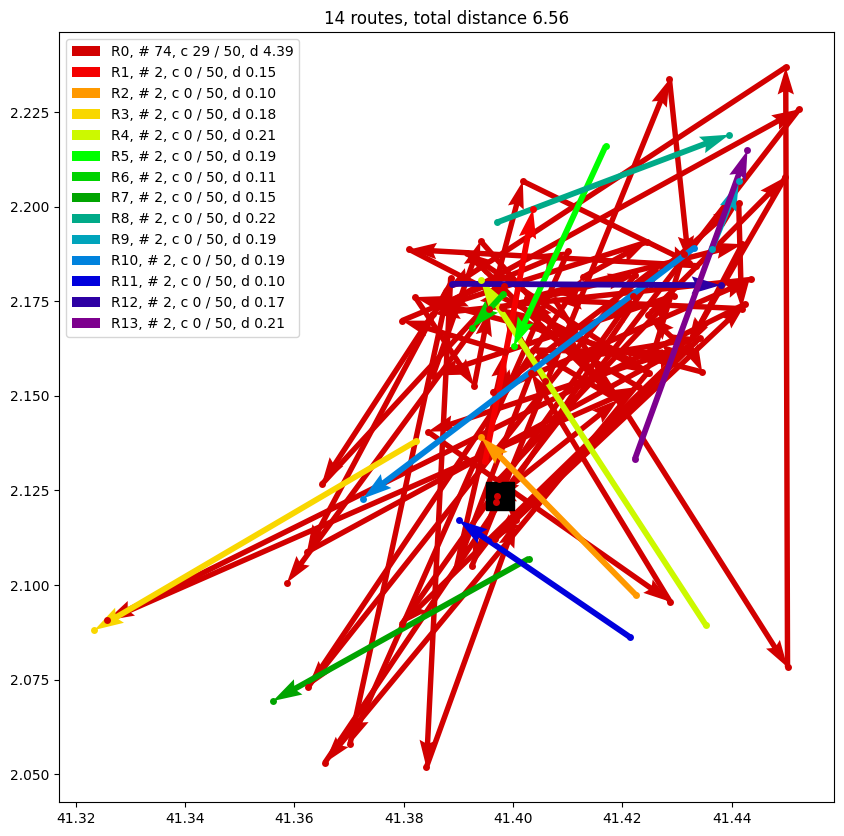

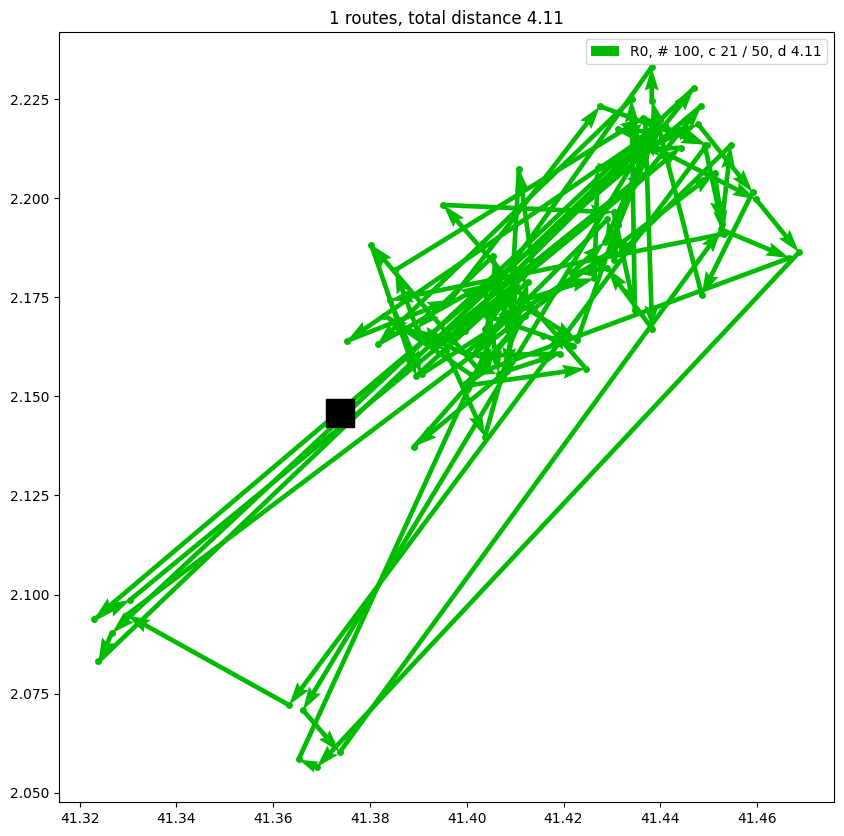

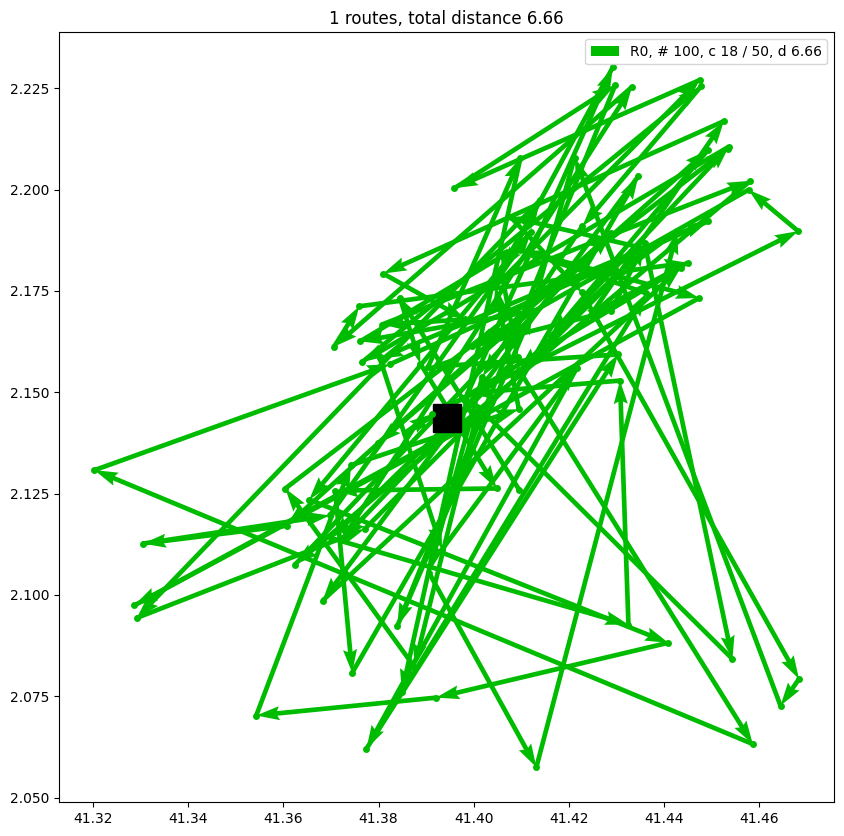

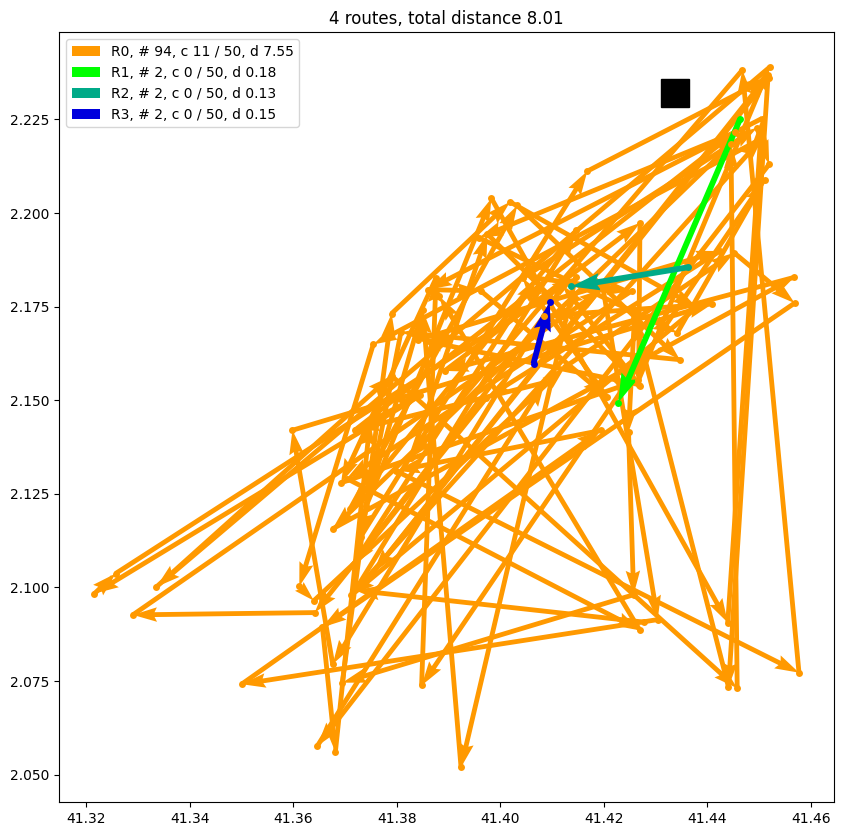

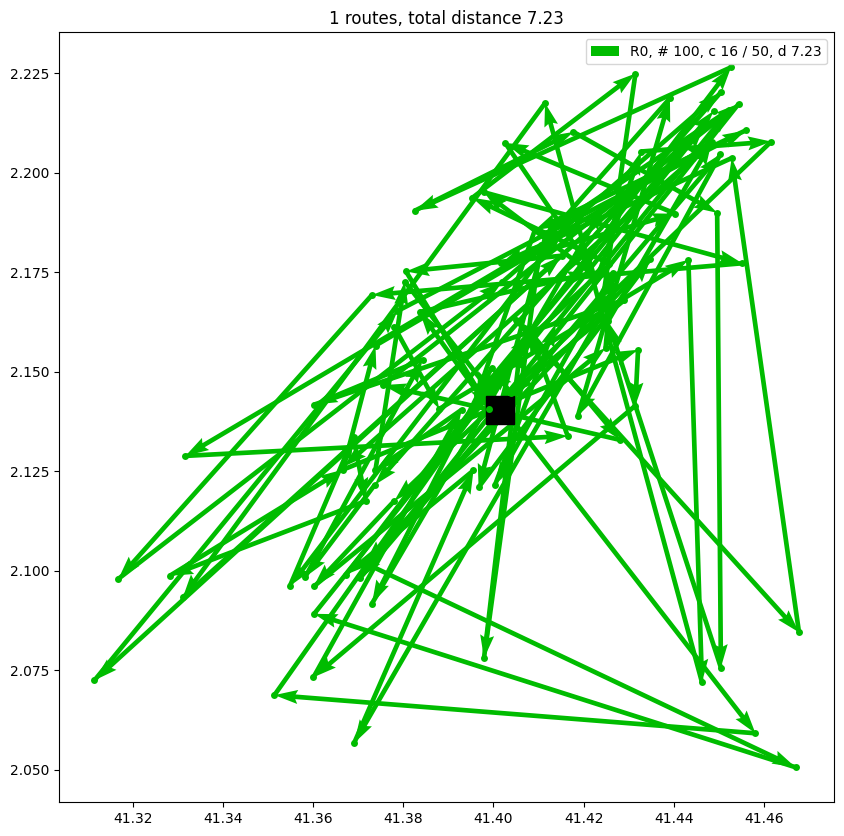

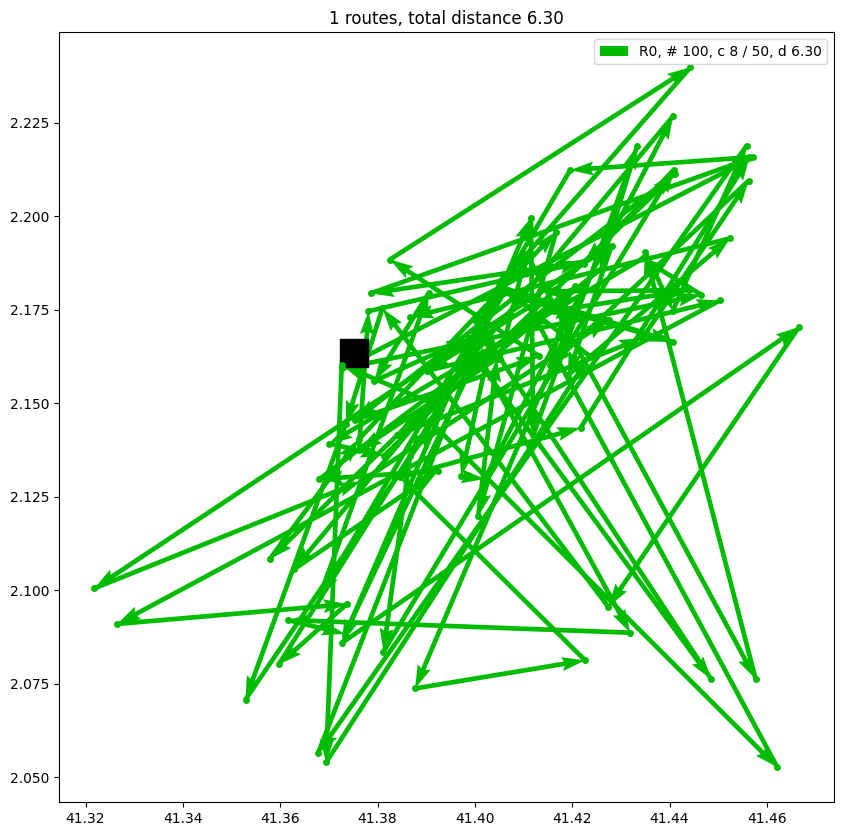

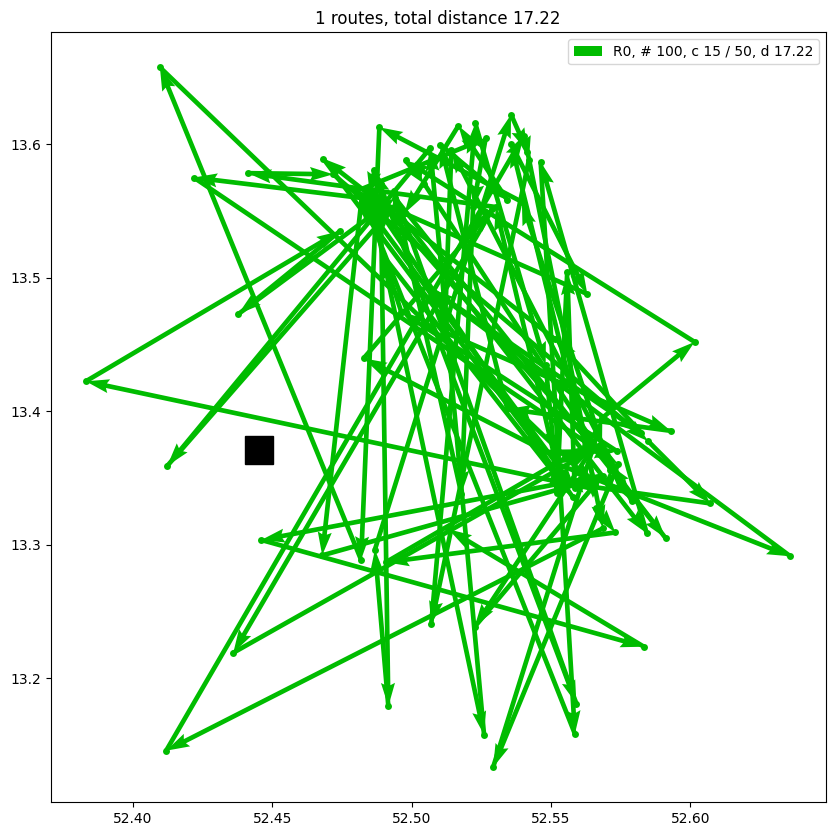

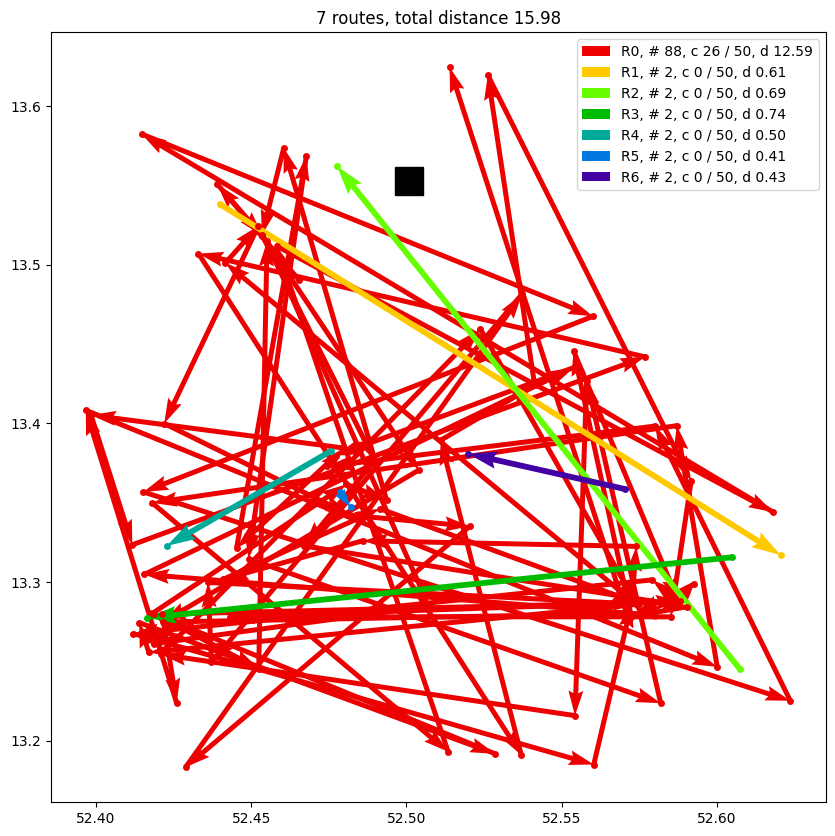

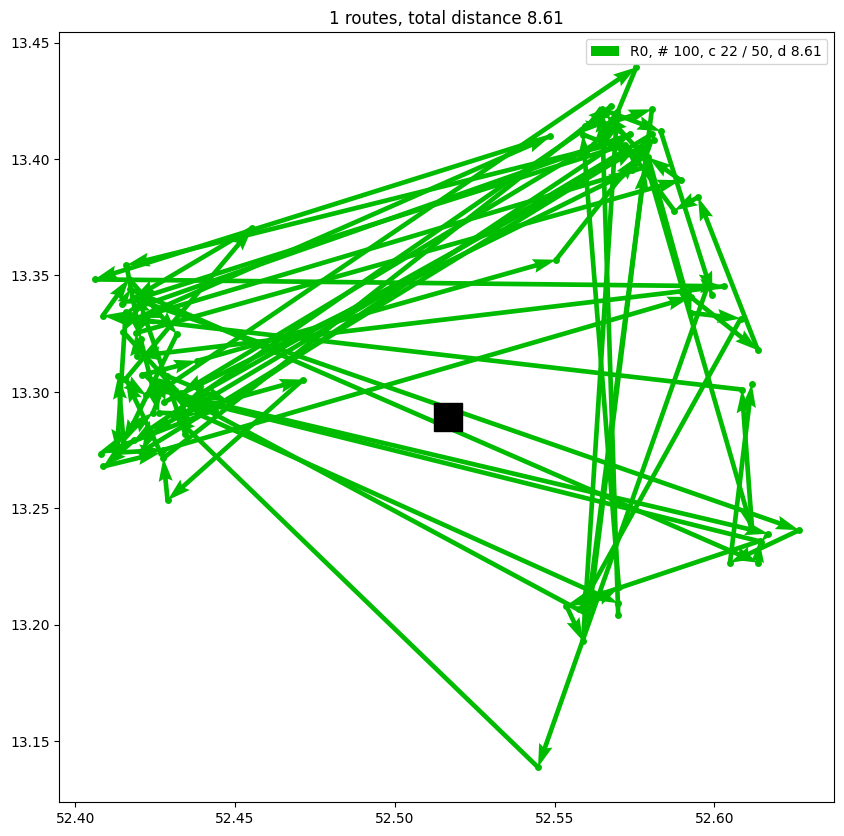

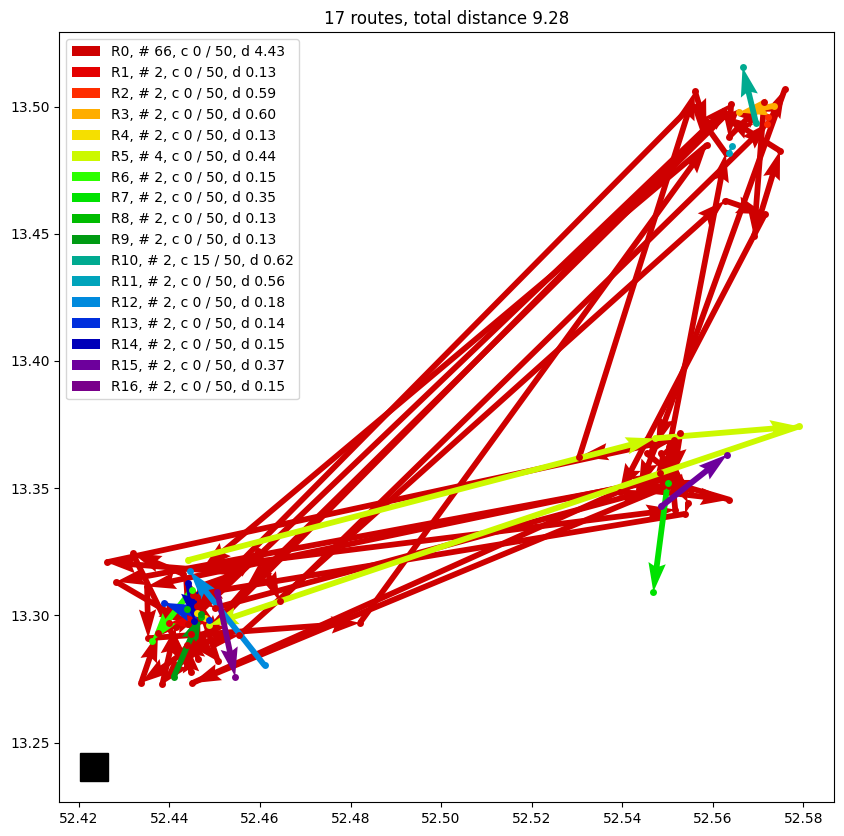

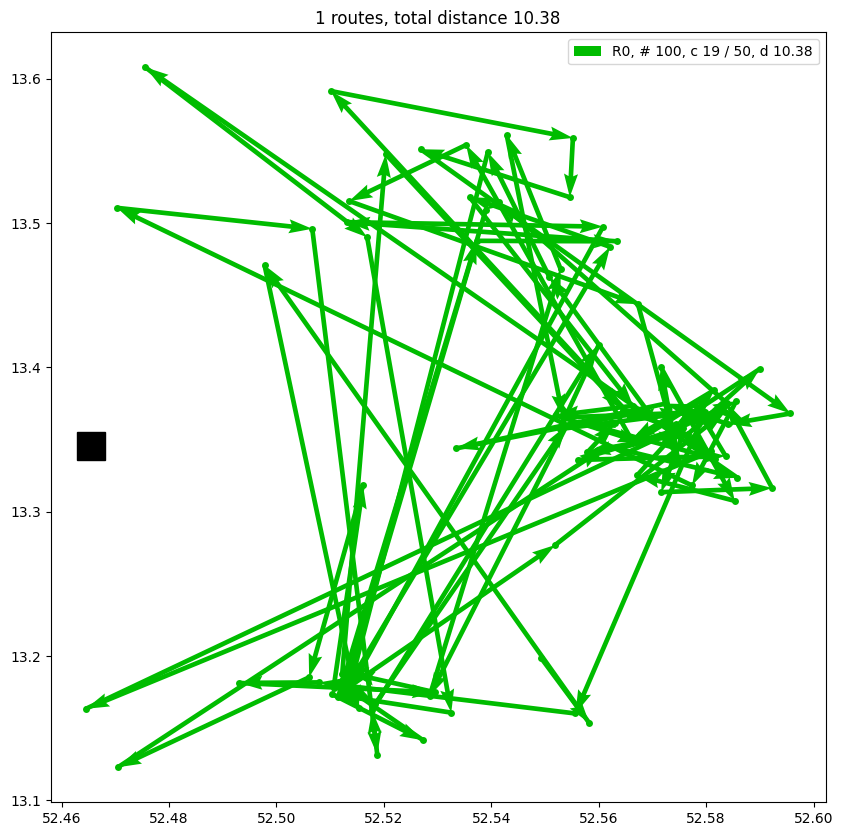

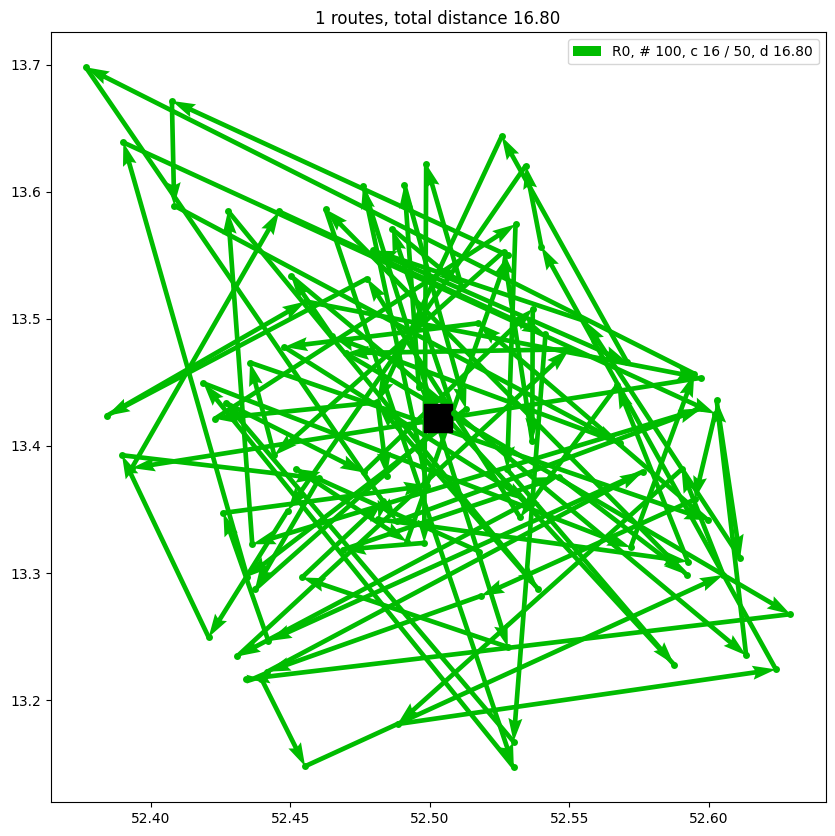

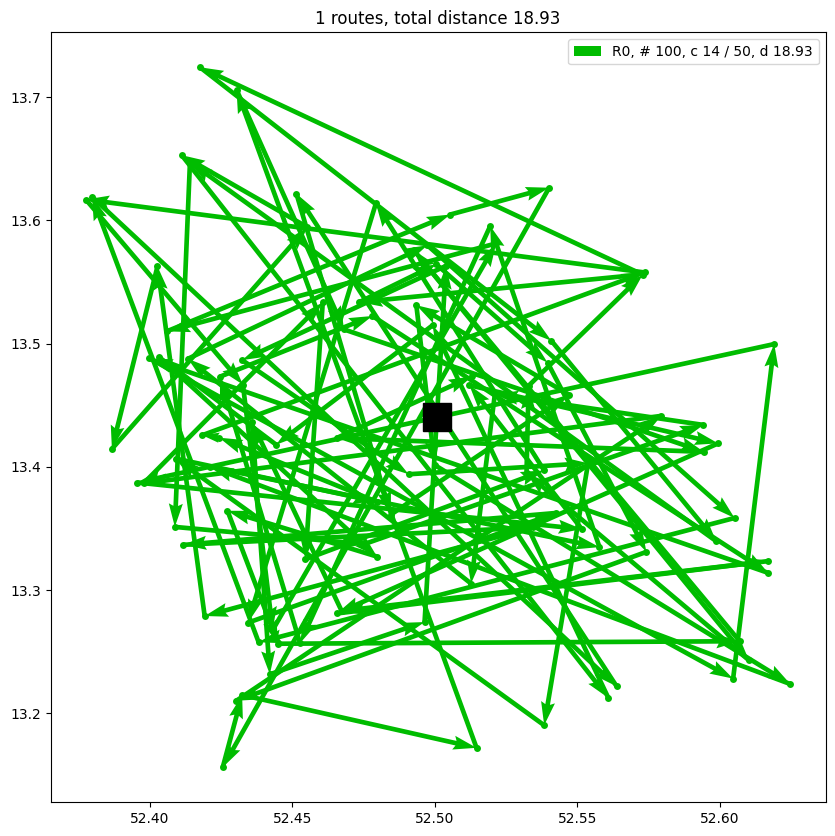

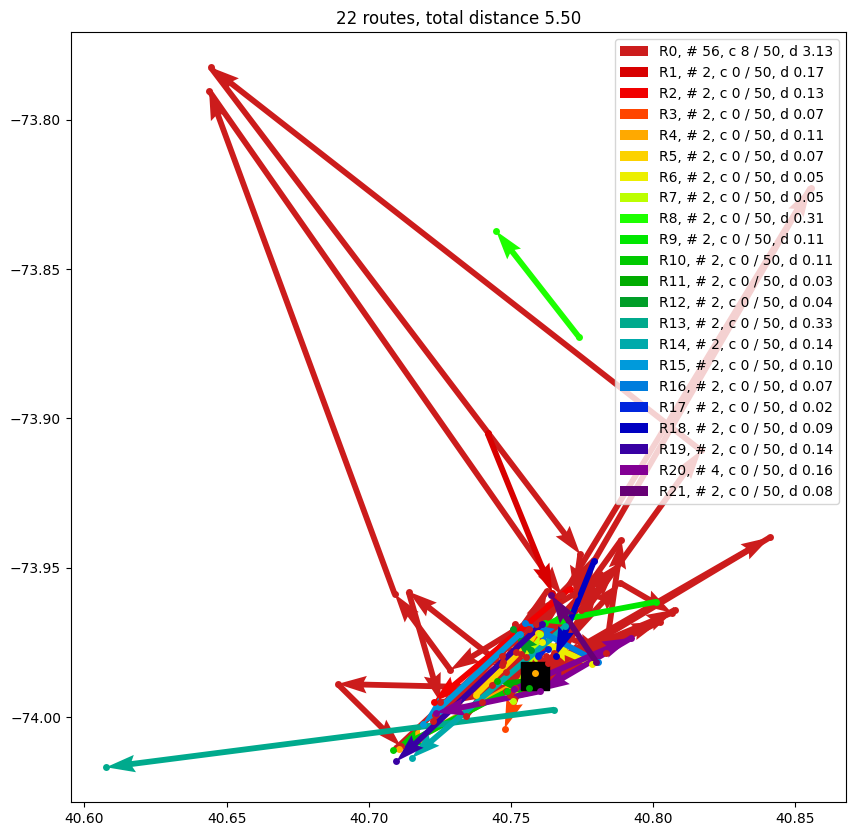

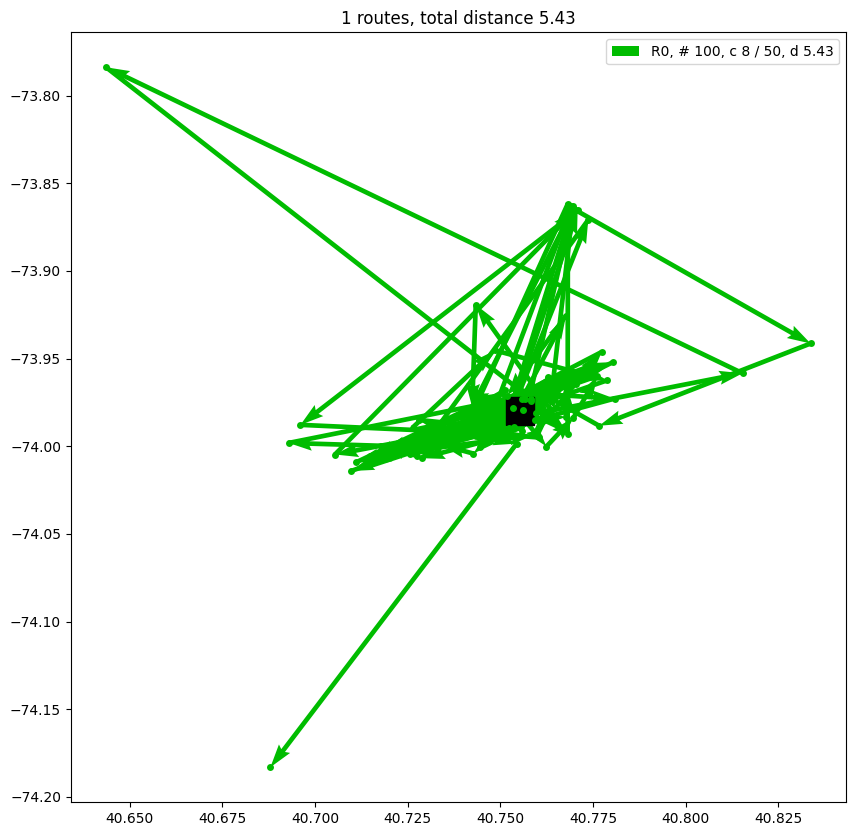

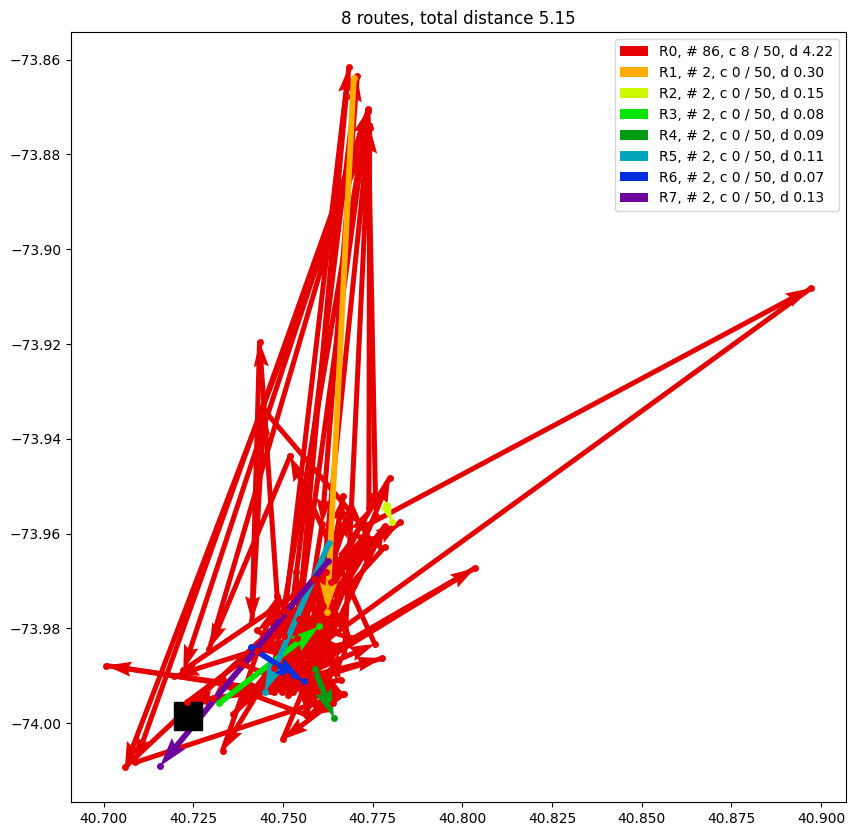

In [27]:
data_path = 'D:/OneDrive - Hanoi University of Science and Technology/Projects/Project 1/Data/Sartori&Buriol/Instances/n100/'
dataset = CPDPTWDataset(data_path)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi = model(batch, return_pi=True)
tours = pi

# Plot the results
for i, (data, tour) in enumerate(zip(dataset, tours)):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=50, round_demand=True)

In [14]:
tours

tensor([[  1,   2,  12,  ..., 100,   0,   0],
        [  1,   2,   3,  ...,   0,   0,   0],
        [  4,   9,   2,  ...,   0,  49,  99],
        ...,
        [  1,   2,   3,  ...,   0,   0,   0],
        [  8,   1,  12,  ...,   0,   0,   0],
        [  3,  37,  20,  ...,   0,   0,   0]])